In [1]:
# Cell 1: 환경 설정 및 라이브러리 로드
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import medfilt
from scipy.ndimage import gaussian_filter
import matplotlib.dates as mdates


# 파일 경로 및 파라미터
CSV_PATH = r"C:\Users\User\Desktop\WIFI-CSI\data\Raw_CSI_To_CSV_NoActivity\merged_csi_data_noactivity.csv"
WIN_SIZE = 64


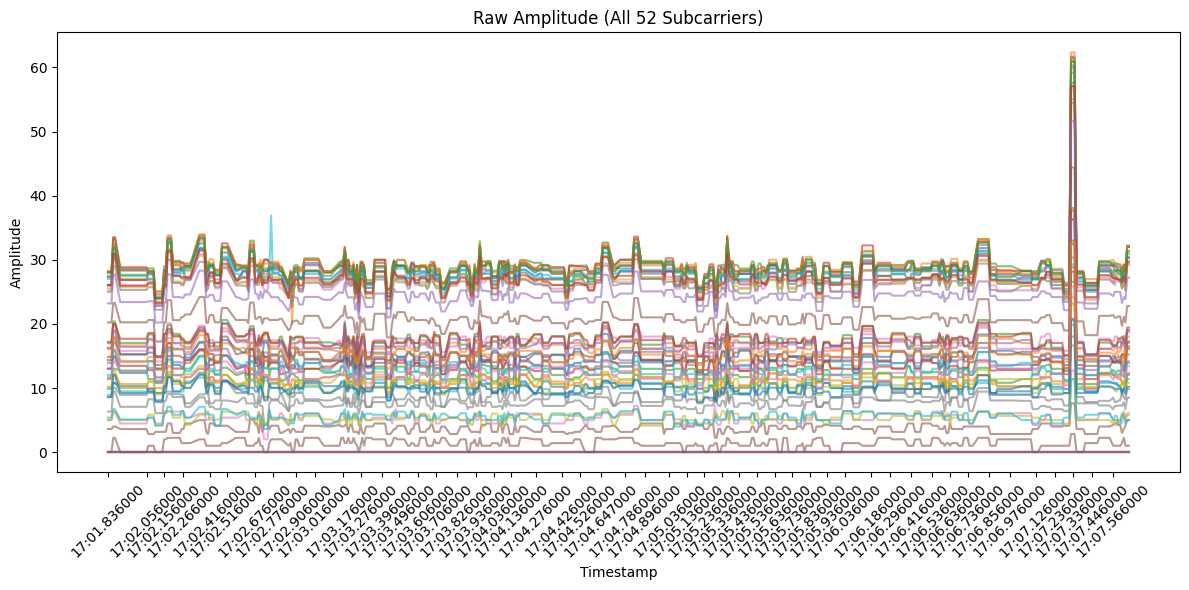

In [2]:
# Cell 2: 데이터 로드 및 Raw Amplitude (모든 서브캐리어)
df = pd.read_csv(CSV_PATH, parse_dates=['timestamp'])
df['timestamp'] = pd.to_datetime(df['timestamp'], format="%H:%M.%S")
# I/Q -> amplitude
I   = df[[f"I{i}" for i in range(52)]].values
Q   = df[[f"Q{i}" for i in range(52)]].values
amp = np.sqrt(I**2 + Q**2)

# plot all subcarriers (first 500 frames)
N = 500
tick_spacing = 10
ts = df['timestamp'][:N]
plt.figure(figsize=(12,6))
for i in range(52):
    plt.plot(ts, amp[:N, i], alpha=0.6)
plt.title("Raw Amplitude (All 52 Subcarriers)")
plt.xlabel("Timestamp")
plt.ylabel("Amplitude")
# 포맷 수정: 분:초.밀리초
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%M:%S.%f'))
plt.xticks(ts[::tick_spacing], rotation=45)
plt.tight_layout()
plt.show()


1분정도의 CSI 데이터 원본 ( 총 5562 row )

In [3]:
# Cell 3: 유틸 함수 정의
def robust_hampel(col, window=5, n_sigma=3):
    """Hampel filter로 이상치 제거"""
    median = medfilt(col, kernel_size=window)
    dev    = np.abs(col - median)
    mad    = np.median(dev)
    out    = dev > n_sigma * mad
    col[out] = median[out]
    return col

def moving_average(sig, win):
    """단순 이동평균"""
    return np.convolve(sig, np.ones(win)/win, mode='valid')


(9984, 41)


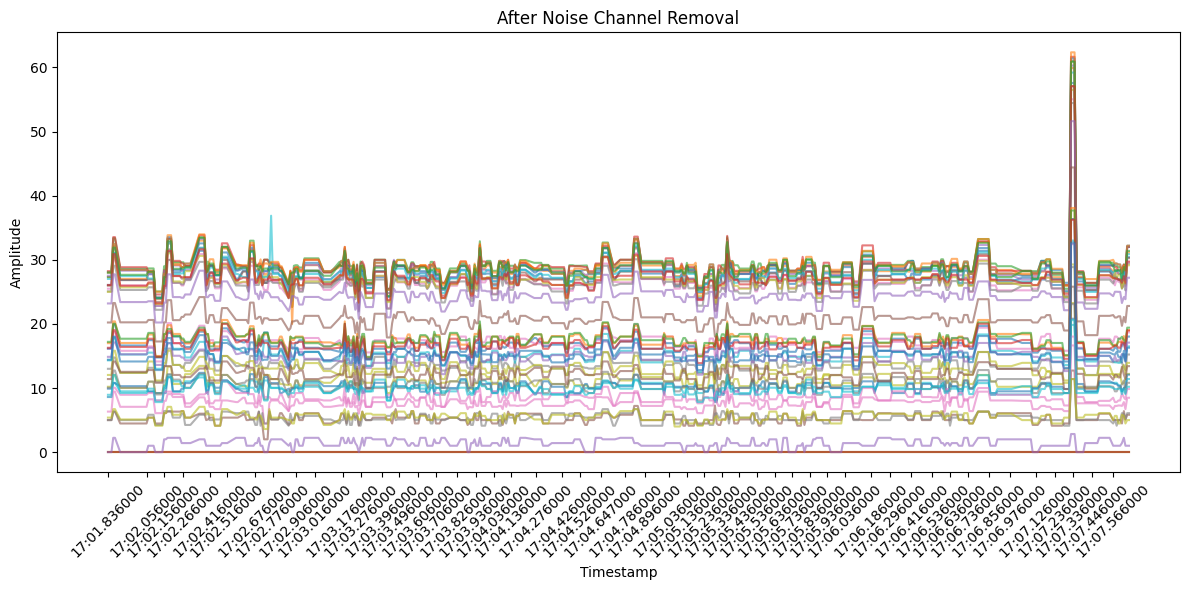

In [4]:
# Cell 4: 노이즈 채널 제거 (21~31) 및 시각화
indices_to_remove = list(range(21,32))
amp_reduced = np.delete(amp, indices_to_remove, axis=1)
print(amp_reduced.shape)
plt.figure(figsize=(12,6))
for i in range(amp_reduced.shape[1]):
    plt.plot(ts, amp_reduced[:N, i], alpha=0.6)
plt.title("After Noise Channel Removal")
plt.xlabel("Timestamp")
plt.ylabel("Amplitude")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%M:%S.%f'))
plt.xticks(ts[::tick_spacing], rotation=45)
plt.tight_layout()


21~ 31번( 11개 ) 서브캐리어 제거

남은 41개의 서브캐리어만 시각화

In [5]:
# Cell 5: 배경 캘리브레이션 (처음 500프레임)
# calibration 파일 경로
CALIB_PATH = r"C:\Users\User\Desktop\WIFI-CSI\CSI_Calibration\L0382_ESP_8_bg_params.csv"

# 2행짜리 CSV: 첫째 행이 mu_bg, 둘째 행이 sigma_bg
calib = pd.read_csv(CALIB_PATH, header=None)
mu_bg    = calib.iloc[0].values.astype(float)
sigma_bg = calib.iloc[1].values.astype(float)

# 0인 σ는 1로 대체 (0으로 나누기 방지)
sigma_bg[sigma_bg == 0] = 1

print("Loaded calibration from file:")
print("mu_bg[:5]   =", mu_bg[:5])
print("sigma_bg[:5]=", sigma_bg[:5])


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\User\\Desktop\\WIFI-CSI\\CSI_Calibration\\L0382_ESP_8_bg_params.csv'

znorm.shape : (5632, 41)


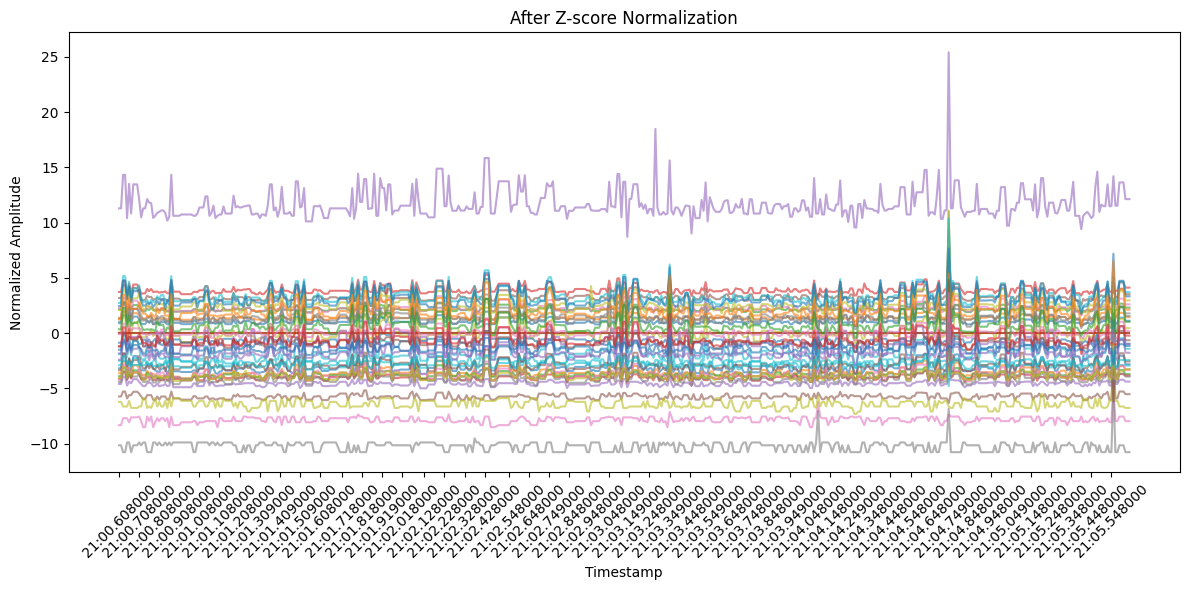

In [27]:
# Cell 6: Z-score 정규화 및 시각화
znorm = (amp_reduced - mu_bg) / sigma_bg
print(f"znorm.shape : {znorm.shape}")
plt.figure(figsize=(12,6))
for i in range(znorm.shape[1]):
    plt.plot(ts, znorm[:N, i], alpha=0.6)
plt.title("After Z-score Normalization")
plt.xlabel("Timestamp")
plt.ylabel("Normalized Amplitude")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%M:%S.%f'))
plt.xticks(ts[::tick_spacing], rotation=45)
plt.tight_layout()


===============================================================

invalid_indices : [4, 9, 14, 15, 16, 17, 18, 27, 28, 29, 35]
(5632, 30)


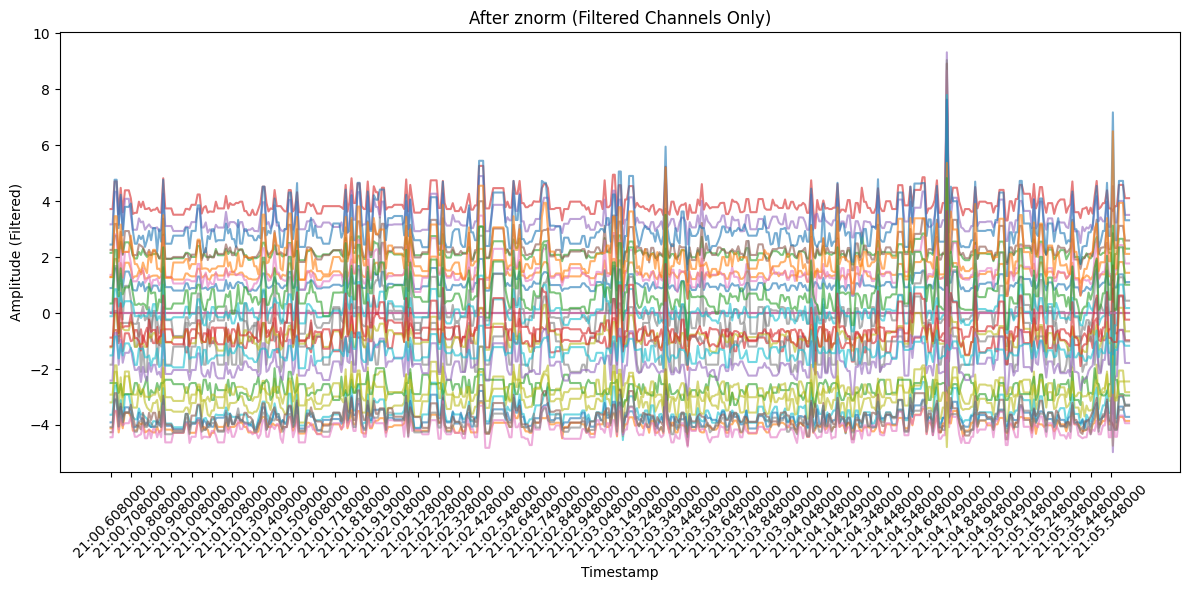

In [28]:
## 맨 위랑 맨 아래만 제거해 보자
#
# 상하한 기준으로 이상 서브캐리어 필터링
threshold_upper = 10
threshold_lower = -5

valid_indices = []
invalid_indices = []
for i in range(znorm.shape[1]):
    ch_max = np.max(znorm[:N, i])
    ch_min = np.min(znorm[:N, i])
    if ch_max < threshold_upper and ch_min >= threshold_lower:
        valid_indices.append(i)
    else:
        invalid_indices.append(i)

# 이상치 제외한 필터링 결과
print(f"invalid_indices : {invalid_indices}")
znorm_reduced = znorm[:, valid_indices]
print(znorm_reduced.shape)
# 시각화
plt.figure(figsize=(12,6))
for i in range(znorm_reduced.shape[1]):
    plt.plot(ts, znorm_reduced[:N, i], alpha=0.6)
plt.title("After znorm (Filtered Channels Only)")
plt.xlabel("Timestamp")
plt.ylabel("Amplitude (Filtered)")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%M:%S.%f'))
plt.xticks(ts[::tick_spacing], rotation=45)
plt.tight_layout()
plt.show()

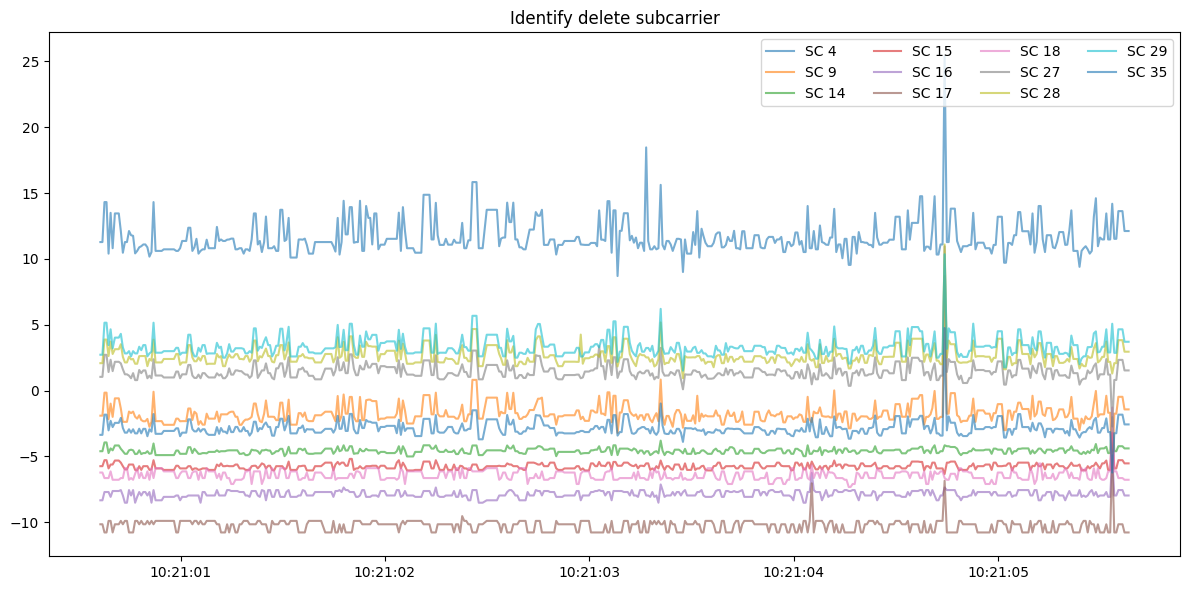

In [29]:
## invalid_indices 서브캐리어 시각화
plt.figure(figsize=(12,6))
for i in invalid_indices:
    plt.plot(ts, znorm[:N, i], alpha=0.6, label=f'SC {i}')
plt.legend(loc='upper right', ncol=4)
plt.title("Identify delete subcarrier")
plt.tight_layout()
plt.show()

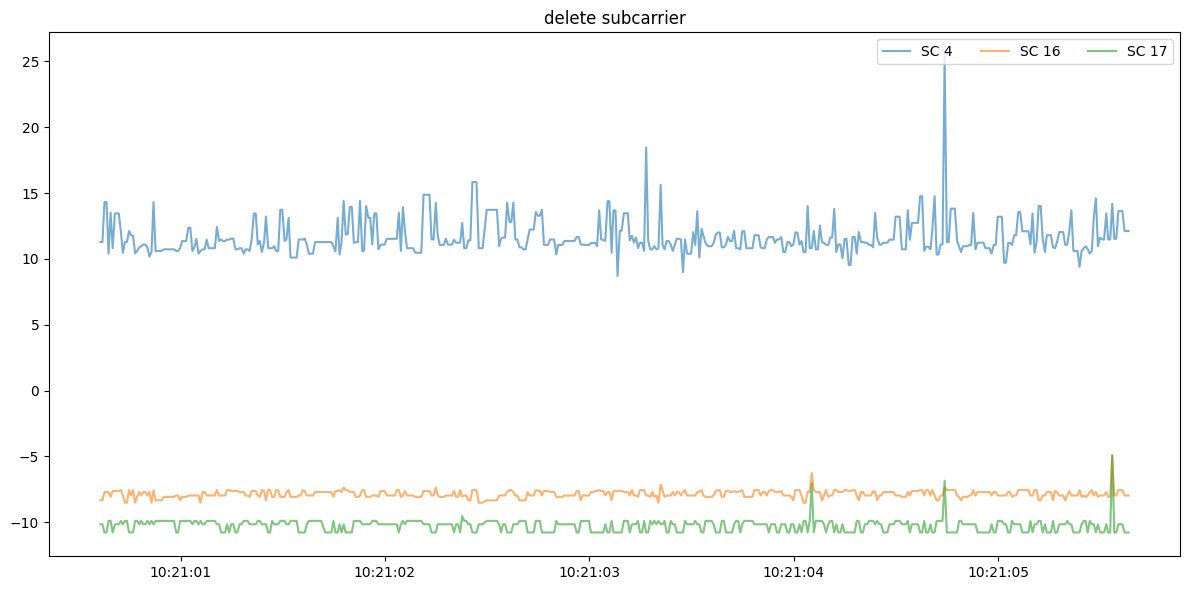

In [30]:
## 뺄뺄거 찾기
plt.figure(figsize=(12,6))    

plt.plot(ts, znorm[:N, 4], alpha=0.6, label=f'SC 4')
plt.plot(ts, znorm[:N, 16], alpha=0.6, label=f'SC 16')
plt.plot(ts, znorm[:N, 17], alpha=0.6, label=f'SC 17')

plt.legend(loc='upper right', ncol=4)
plt.title("delete subcarrier")
plt.tight_layout()

==========================================================

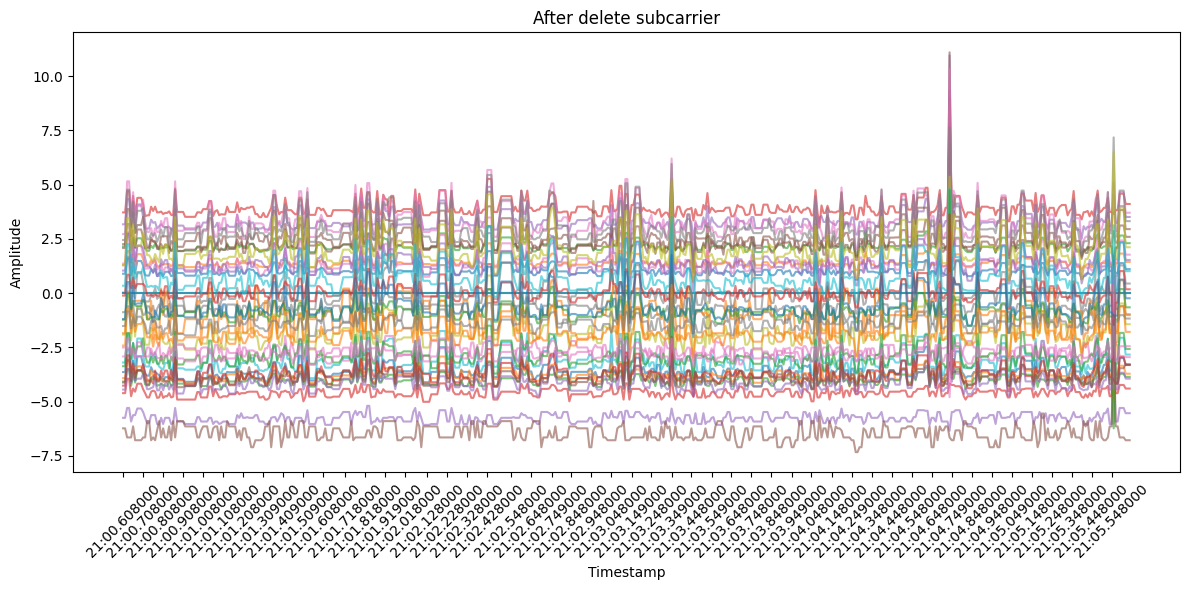

In [31]:
# znorm 에서 4, 16, 17 번 서브캐리어 삭제 후 시각화 
znorm_reduced = np.delete(znorm, [4, 16, 17], axis=1)

plt.figure(figsize=(12,6))
for i in range(znorm_reduced.shape[1]):
    plt.plot(ts, znorm_reduced[:N, i], alpha=0.6)
plt.title("After delete subcarrier")
plt.xlabel("Timestamp")
plt.ylabel("Amplitude")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%M:%S.%f'))
plt.xticks(ts[::tick_spacing], rotation=45)
plt.tight_layout()
plt.show()


Z-score Normalization
1. 목적 :
    * 각 서브캐리어를 과거 정지상태의 평균 & 표준편차로 정규화 : Z-score ( 값이 평균으로부터 얼마나 떨어져 있는지를 표준편차 단위로 측정한 것)
2. 특이점 : 
    * 진폭이 0을 중심으로 분포됨
    * Amplitude 10~15 : 해당 서브캐리어가 민감하거나, Z-score 정규화 시 표준편차가 작았을 확률 있음
    * Amplitude -5~ -10 : 움직임에 거의 반응 없는 서브캐리어들

(5632, 38)


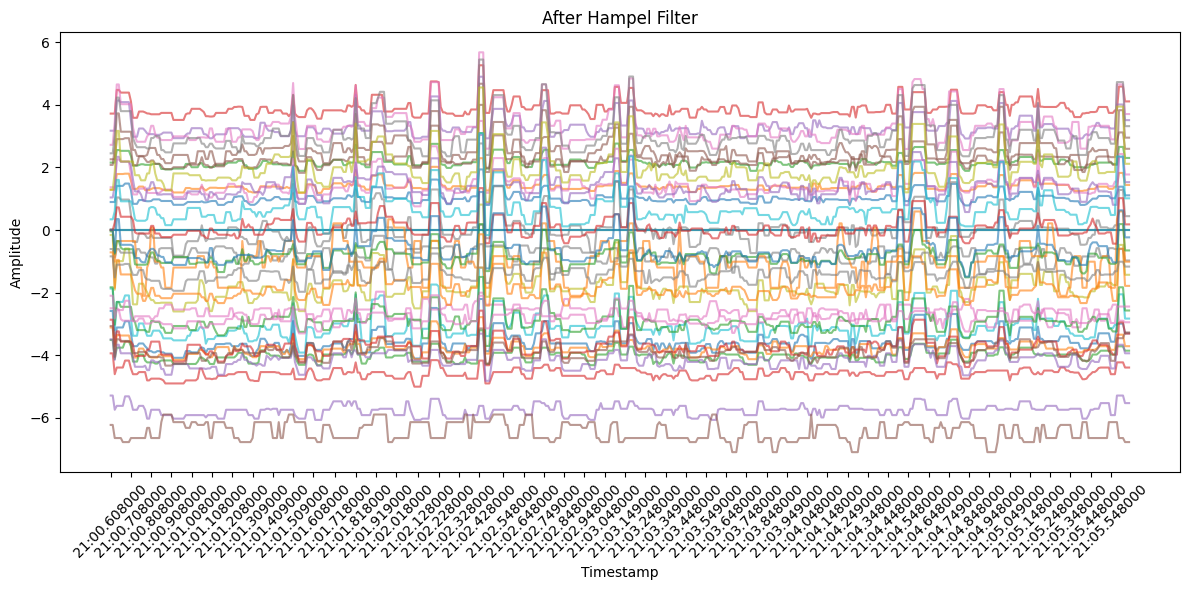

In [32]:
# Cell 7: Hampel 필터 적용 및 시각화
Hampel_filtered = np.apply_along_axis(robust_hampel, 0, znorm_reduced)
print(Hampel_filtered.shape)

plt.figure(figsize=(12,6))
for i in range(Hampel_filtered.shape[1]):
    plt.plot(ts, Hampel_filtered[:N, i], alpha=0.6)
plt.title("After Hampel Filter")
plt.xlabel("Timestamp")
plt.ylabel("Amplitude")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%M:%S.%f'))
plt.xticks(ts[::tick_spacing], rotation=45)
plt.tight_layout()


Hampel 필터 적용
1. 목적 : 
    * 이상치 제거 
2. 특이점 :
    * 그래프가 전반적으로 매끄러워짐


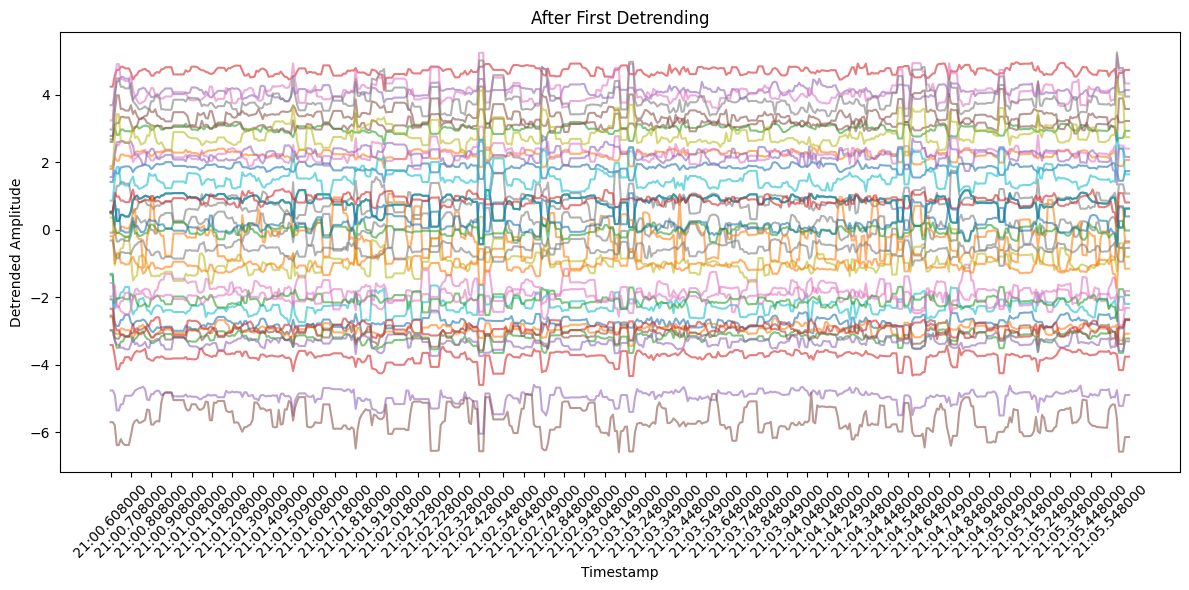

In [33]:
# Cell 8-1: Detrending (패킷별 평균 제거) 및 시각화
# 1단계: 프레임 평균 제거 (서브캐리어 간 중심화)
mean_per_frame = np.mean(Hampel_filtered, axis=1, keepdims=True)
detrended_packet = Hampel_filtered - mean_per_frame  # shape 유지 (N, 41)

plt.figure(figsize=(12,6))
for i in range(detrended_packet.shape[1]):
    plt.plot(ts, detrended_packet[:N, i], alpha=0.6)
plt.title("After First Detrending")
plt.xlabel("Timestamp")
plt.ylabel("Detrended Amplitude")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%M:%S.%f'))
plt.xticks(ts[::tick_spacing], rotation=45)
plt.tight_layout()

프레임 별 서브캐리어 평균 제거
1. 목적 : 
    * 각 프레임(시간) 내 서브캐리어 평균 제거해 -> trend 제거, 서브캐리어 간 차이 강조 
    

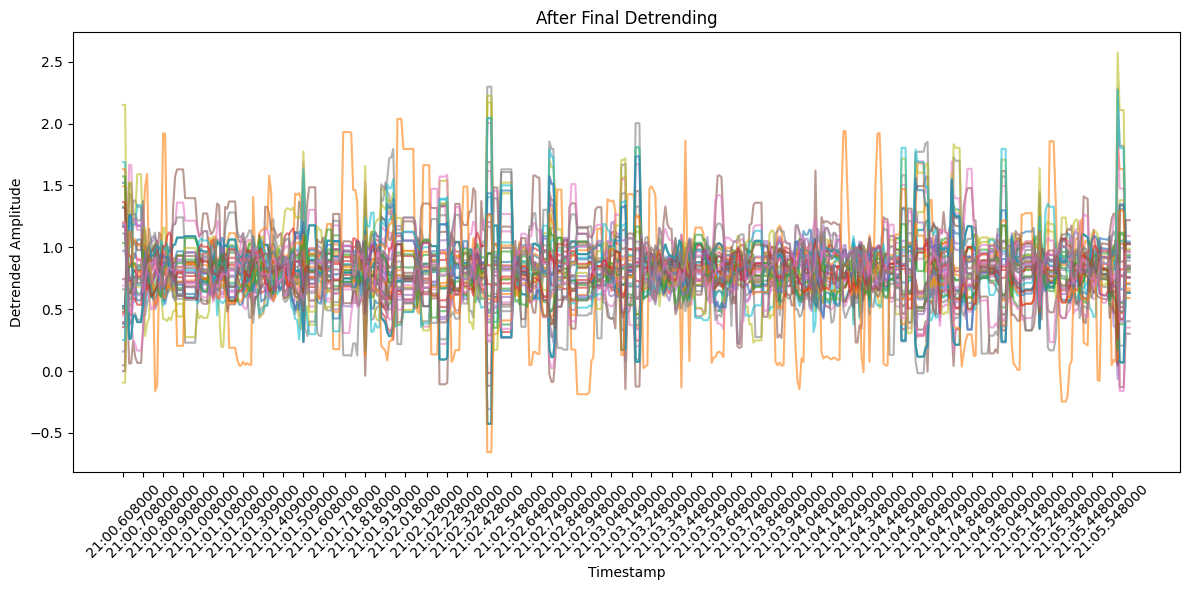

In [34]:
# Cell 8-2 : Detrending (패킷별 평균 제거) 및 시각화
# 2단계: 기준선 제거 (시간축 기준 평균)
mean_current = np.mean(Hampel_filtered, axis=0)
mean_historical = np.mean(Hampel_filtered[:30], axis=0)  # 슬라이딩 윈도우 기준선
combined_mean = (mean_current + mean_historical) / 2

# 최종 detrended 결과
detrended = detrended_packet - combined_mean

plt.figure(figsize=(12,6))
for i in range(detrended.shape[1]):
    plt.plot(ts, detrended[:N, i], alpha=0.6)
plt.title("After Final Detrending")
plt.xlabel("Timestamp")
plt.ylabel("Detrended Amplitude")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%M:%S.%f'))
plt.xticks(ts[::tick_spacing], rotation=45)
plt.tight_layout()


서브캐리어별 시간축 평균 제거
1. 목적 : 
    * 모든 서브캐리어를 0을 기준으로 만들어서 
    * 서브캐리어 간 기준선 차이를 제거하고 변동성만 남김.

38
5632


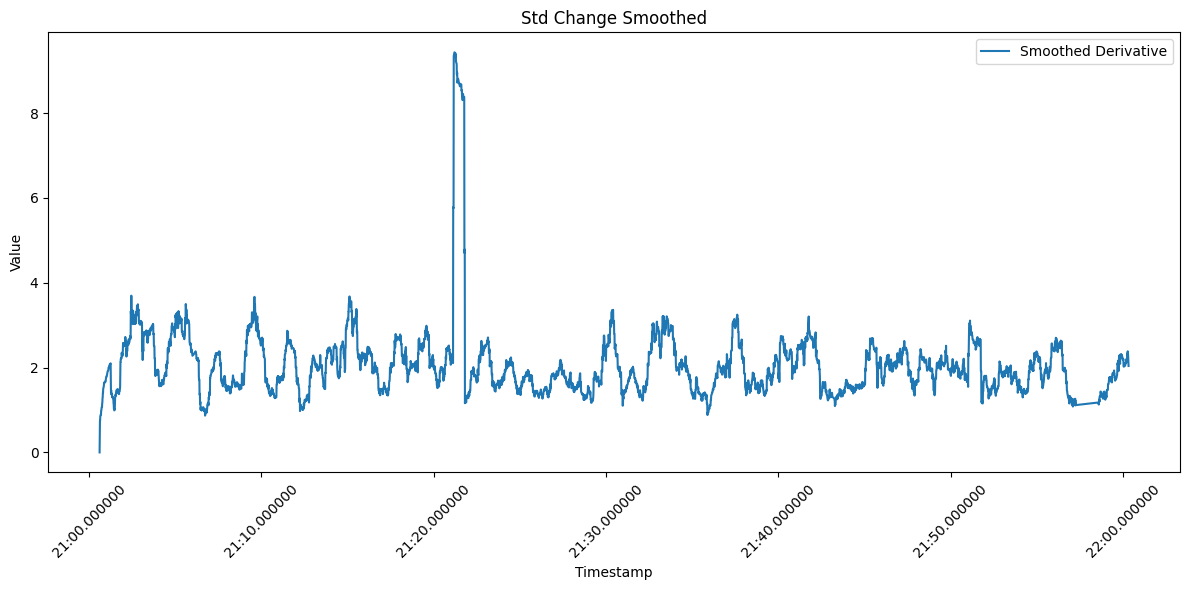

In [35]:
# Cell 9: 표준편차 변화량 + 이동평균 시각화
std_per_pkt = np.std(detrended, axis=1)
print(len(detrended[1]))
print(len(std_per_pkt))
deriv = np.abs(np.diff(std_per_pkt))

prev_samples = np.zeros(WIN_SIZE)
padded_signal = np.concatenate([prev_samples, deriv])
window = np.ones(WIN_SIZE)
convolved = np.convolve(padded_signal, window, mode='valid')
smoothed = convolved[-len(deriv):]

valid_len = len(smoothed)
plt.figure(figsize=(12,6))
plt.plot(df['timestamp'][1:1+valid_len], smoothed, label='Smoothed Derivative')
plt.title("Std Change Smoothed")
plt.xlabel("Timestamp")
plt.ylabel("Value")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%M:%S.%f'))
plt.xticks( rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

STD change smoothed 
모든 서브캐리어들의 진폭 변화량이 얼마나 급격하게 변했는가

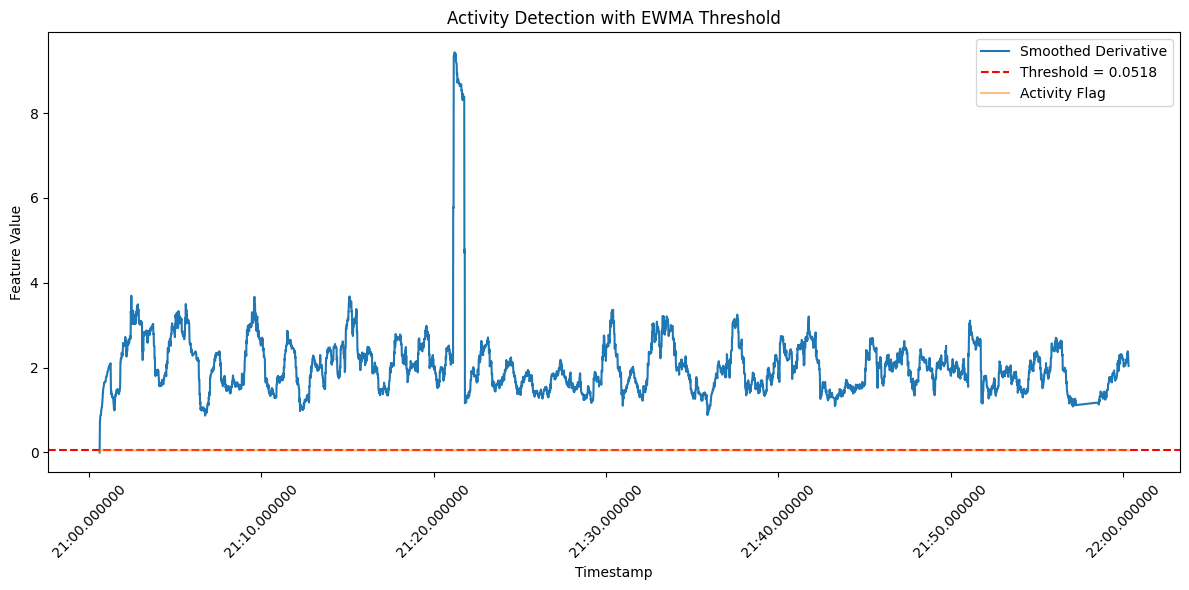

In [36]:
# Cell 10: EWMA & Threshold & Activity Detection 시각화
alpha = 0.01
ewma = 0
avgSig = np.mean(smoothed)
ewma = alpha * avgSig + (1 - alpha) * ewma
Th = 2.5 * ewma
ActivityFlag = (smoothed > Th).astype(float)


plt.figure(figsize=(12,6))
plt.plot(df['timestamp'][1:1+valid_len], smoothed, label="Smoothed Derivative")
plt.axhline(Th, color='red', linestyle='--', label=f"Threshold = {Th:.4f}")
plt.plot(df['timestamp'][1:1+valid_len], ActivityFlag * Th, label="Activity Flag", linestyle='-', alpha=0.5)
plt.title("Activity Detection with EWMA Threshold")
plt.xlabel("Timestamp")
plt.ylabel("Feature Value")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%M:%S.%f'))
plt.xticks( rotation=45)
plt.tight_layout()
plt.legend()
plt.show()


++++++++++++++++++++++++++++++++++++++++++++++++++

In [37]:
# std 기반 smoothed 곡선
target_signal = smoothed

# detrended: (T, C)
correlations = []

for i in range(detrended.shape[1]):
    signal = np.abs(np.diff(detrended[:, i]))
    
    # 이동 평균 (같은 방식으로 맞춰줘야 비교 가능)
    padded = np.concatenate([np.zeros(WIN_SIZE), signal])
    conv = np.convolve(padded, np.ones(WIN_SIZE), mode='valid')
    smoothed_sc = conv[-len(signal):]

    # 길이 맞춰서 비교
    min_len = min(len(smoothed_sc), len(target_signal))
    corr = np.corrcoef(smoothed_sc[:min_len], target_signal[:min_len])[0, 1]
    correlations.append(corr)

best_index = int(np.argmax(correlations))
print(f" 전체 변화를 가장 잘 대표하는 서브캐리어는: SC {best_index}")


 전체 변화를 가장 잘 대표하는 서브캐리어는: SC 0


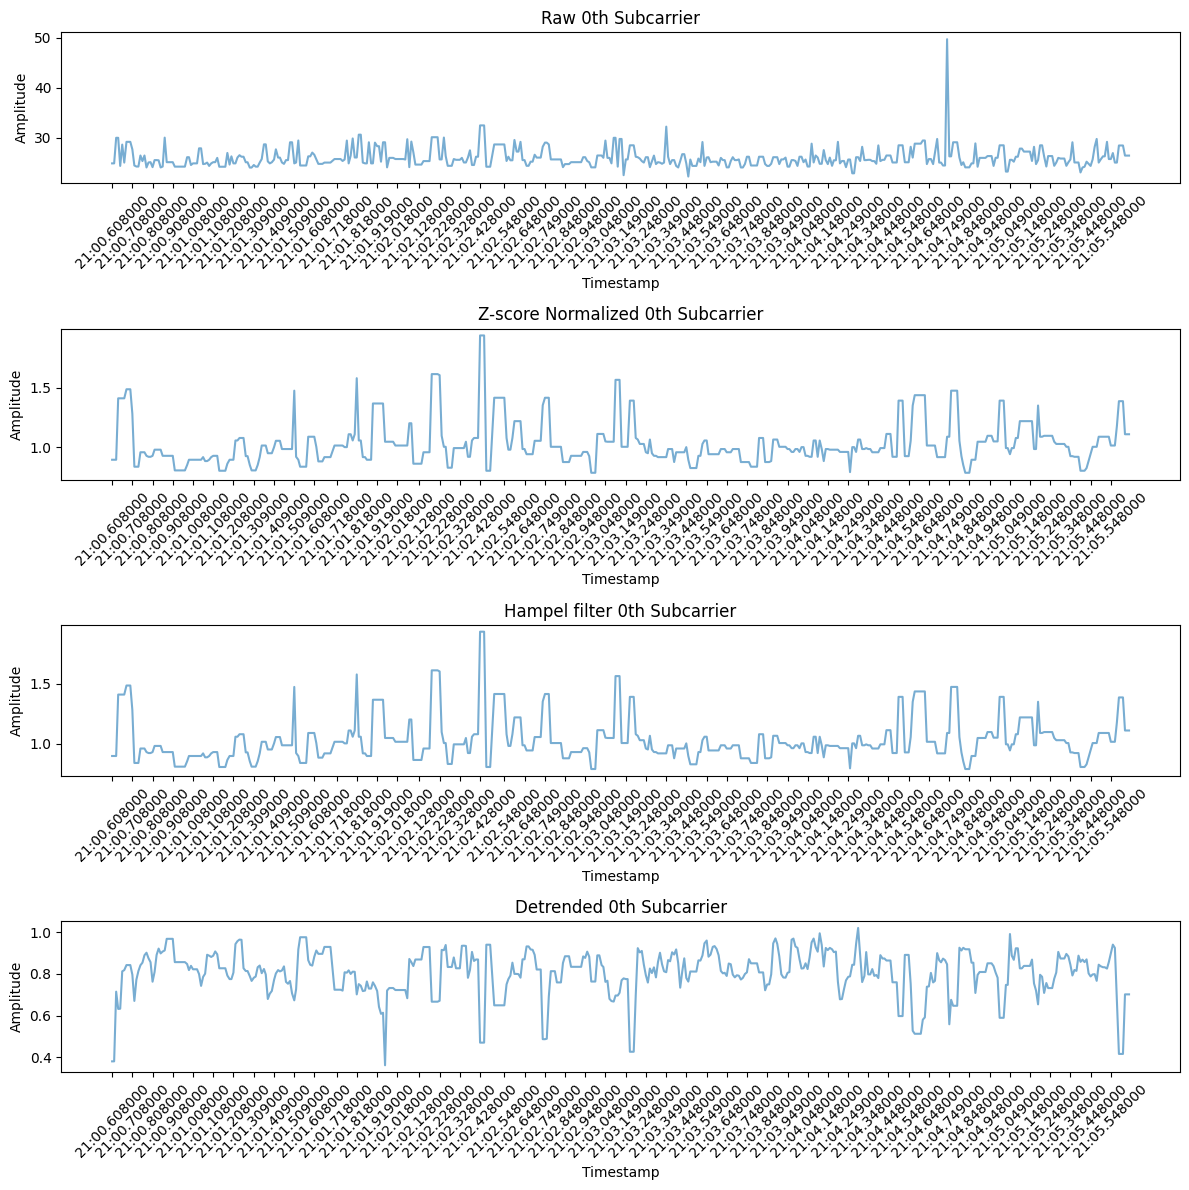

In [38]:
# 0th 서브캐리어 변화과정
plt.figure(figsize=(12,12))

plt.subplot(4,1,1)
plt.plot(ts, amp_reduced[:N, 0], alpha=0.6)
plt.title("Raw 0th Subcarrier")
plt.xlabel("Timestamp")
plt.ylabel("Amplitude")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%M:%S.%f'))
plt.xticks(ts[::tick_spacing], rotation=45)

plt.subplot(4,1,2)
plt.plot(ts, znorm_reduced[:N, 0], alpha=0.6)
plt.title("Z-score Normalized 0th Subcarrier")
plt.xlabel("Timestamp")
plt.ylabel("Amplitude")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%M:%S.%f'))
plt.xticks(ts[::tick_spacing], rotation=45)

plt.subplot(4,1,3)
plt.plot(ts, Hampel_filtered[:N, 0], alpha=0.6)
plt.title("Hampel filter 0th Subcarrier")
plt.xlabel("Timestamp")
plt.ylabel("Amplitude")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%M:%S.%f'))
plt.xticks(ts[::tick_spacing], rotation=45)

plt.subplot(4,1,4)
plt.plot(ts, detrended[:N, 0], alpha=0.6)
plt.title("Detrended 0th Subcarrier")
plt.xlabel("Timestamp")
plt.ylabel("Amplitude")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%M:%S.%f'))
plt.xticks(ts[::tick_spacing], rotation=45)

plt.tight_layout()
plt.show()

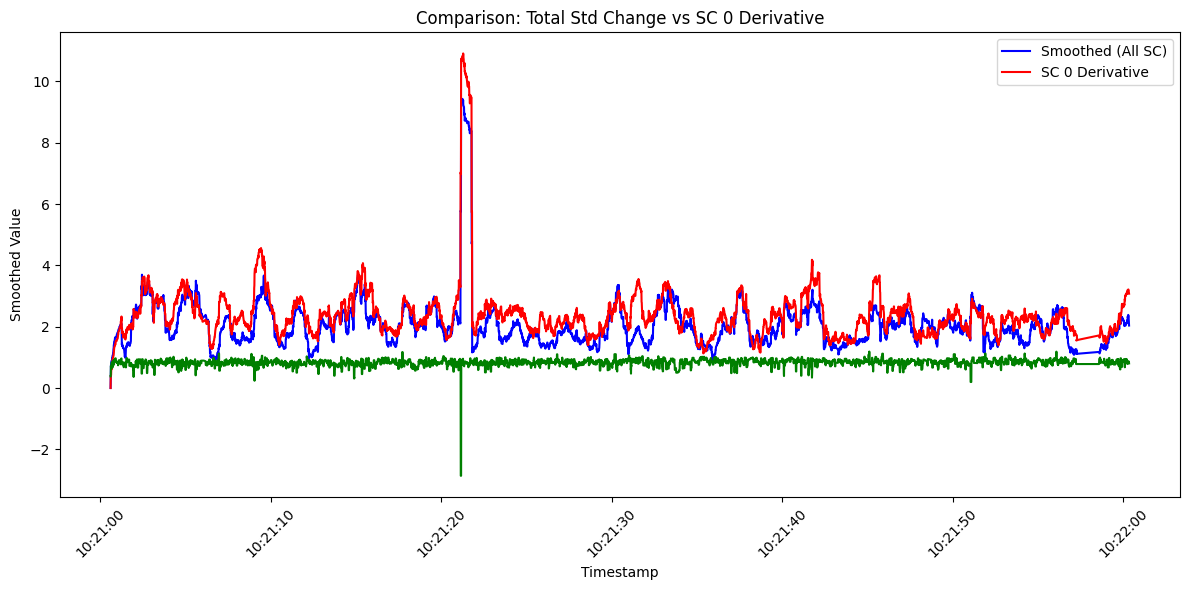

In [39]:
# SC 0의 변화량 계산 (절댓값 미분 + 이동 평균)
sc_index = 0
sc_signal = detrended[:, sc_index]
sc_diff = np.abs(np.diff(sc_signal))

# 이동 평균 적용
padded_sc = np.concatenate([np.zeros(WIN_SIZE), sc_diff])
smoothed_sc0 = np.convolve(padded_sc, np.ones(WIN_SIZE), mode='valid')
smoothed_sc0 = smoothed_sc0[-len(sc_diff):]  # 길이 맞추기

# smoothed: 전체 std 기반 변화량 (기존)
# 길이 맞춰주기
min_len = min(len(smoothed), len(smoothed_sc0))
time_base = df['timestamp'][1:1+min_len]

# 시각화
plt.figure(figsize=(12,6))
plt.plot(time_base, smoothed[:min_len], label='Smoothed (All SC)', color='blue')
plt.plot(time_base, smoothed_sc0[:min_len], label='SC 0 Derivative', color='red')
plt.plot(time_base, detrended[:min_len, best_index], color='green')
plt.title("Comparison: Total Std Change vs SC 0 Derivative")
plt.xlabel("Timestamp")
plt.ylabel("Smoothed Value")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
